This AlexNet model was originally posted on Kaggle by Sanya9. 
I make changes by explaining certain topics more in depth and modifying parameters. 


In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# The Task
In this notebook, we are trying to create an algorithm to classify a wide range (7, to be precise) of emotions based on facial expressions. For image classification, we have used the AlexNet DCNN.


# Why AlexNet?
AlexNet was the winner of the 2012 ImageNet challenge. AlexNet had a remarkable intervention of using **relu** activation function to increase the efficiency by over 6 times by reducing the chances of Vanishing Gradient (VG) problems. 
Another advantage AlexNet has is that overlappping maxpooling layers considerably improve model top-1 and top-5 accuracies.

The model consists of a total of 8 layers: five layers with a combination of max pooling followed by 3 fully connected layers. AlexNet was revolutionary in its field because it was the first model of its kind to introduce consecutive convolution layers in its architecture. 
![AlexNet Architecture](https://www.researchgate.net/profile/Nicola-Strisciuglio/publication/339756908/figure/fig5/AS:866265283457032@1583545146587/AlexNet-architecture-used-as-the-baseline-model-for-the-analysis-of-results-on-the.png)

It is important to note that AlexNet accepts input images of size: **227X227X3**






# Importing Libraries

In [25]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
import datetime

import datetime
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.6.4
numpy Version: 1.21.6


# Generating list of train images, classes and Class Names

In [26]:
data_dir = pathlib.Path("../input/emotion-detection-fer/train")
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)
# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" ])
print(CLASS_NAMES)
# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)


28709
['fearful' 'disgusted' 'angry' 'neutral' 'sad' 'surprised' 'happy']
7


# Creating Data Generator Objects

In [27]:
#path to write the split data to:
data_dir2 = pathlib.Path("../input/emotion-detection-fer/test")

BATCH_SIZE = 64             # Can be of size 2^n, but not restricted to. for the better utilization of memory

IMG_HEIGHT = 227            # input Shape required by the model this can't be modified. 
IMG_WIDTH = 227             # input Shape required by the model

STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# Rescaling the pixel values from 0~255 to 0~1 For RGB Channels of the image.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# training_data for model training
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))

val_data_gen = image_generator.flow_from_directory(directory=str(data_dir2),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True, 
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [28]:
!pip install tensorflow-addons

# Compiling and Summarizing the Model

In [29]:
# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam( 0.0005),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


In [30]:
num_classes = 7
model = AlexNet((227, 227, 3), num_classes)
model.summary()

Model: "alex_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 256)       8

# Training the Model on 20 Epochs

In [ ]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=25,
    validation_data=val_data_gen
    
)

# Saving the model
model.save('AlexNet_saved_model/')
print("Total time: ", time.time() - start, "seconds")

Epoch 1/25
449/449 [==============================] - 85s 190ms/step - loss: 0.1124 - accuracy: 0.9624 - val_loss: 2.9849 - val_accuracy: 0.5600
Epoch 2/25
449/449 [==============================] - 88s 195ms/step - loss: 0.1188 - accuracy: 0.9609 - val_loss: 2.7227 - val_accuracy: 0.5704
Epoch 3/25
449/449 [==============================] - 90s 201ms/step - loss: 0.0957 - accuracy: 0.9677 - val_loss: 2.8875 - val_accuracy: 0.5616
Epoch 4/25
449/449 [==============================] - 87s 195ms/step - loss: 0.0981 - accuracy: 0.9674 - val_loss: 3.2625 - val_accuracy: 0.5607
Epoch 5/25
449/449 [==============================] - 83s 186ms/step - loss: 0.1003 - accuracy: 0.9658 - val_loss: 3.1745 - val_accuracy: 0.5677
Epoch 6/25
449/449 [==============================] - 86s 192ms/step - loss: 0.0923 - accuracy: 0.9696 - val_loss: 3.2195 - val_accuracy: 0.5606
Epoch 7/25
449/449 [==============================] - 80s 178ms/step - loss: 0.0790 - accuracy: 0.9741 - val_loss: 3.0395 - val_ac

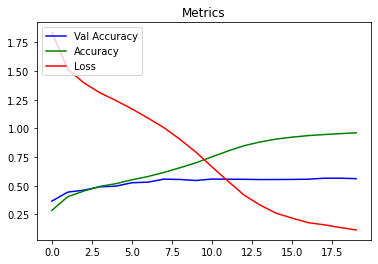

In [32]:
def plot_hist(history):
    #plt.plot(history.history["val_sensitivity_at_specificity"], color='red')
    #plt.plot(history.history["val_auc"], color='blue')
    #plt.plot(history.history["val_specificity_at_sensitivity"], color='yellow')
    plt.plot(history.history["val_accuracy"],color='blue')
    plt.plot(history.history["accuracy"],color='green')
    plt.plot(history.history["loss"],color='red')

    
    plt.title("Metrics")
    
    
    plt.legend(["Val Accuracy","Accuracy","Loss"], loc="upper left")
    plt.show()


plot_hist(history)